Neural Network Modelling

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
from expected_score_model.evaluation.pytorch_evaluator import PyTorchEvaluator

In [3]:
from expected_score_model.modelling.hyperparameter_tuning.nn import HyperparameterTuner
from expected_score_model.modelling.supermodel.supernn import MulticlassNeuralNetwork

In [4]:
from expected_score_model.preprocessing.preprocessor import ExpectedScorePreprocessor
from expected_score_model.preprocessing.response import create_expected_score_response

Data

In [5]:
chains = pd.read_csv('/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/AFL_Chains.csv')

In [6]:
chains = create_expected_score_response(chains)

In [7]:
chains.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal
0,NaN,1,Brisbane,centreBounce,turnover,1.0,0.0,Centre Bounce,NaN,NaN,NaN,1.0,0.0,0.0,0.0,Sydney,Brisbane,right,141.0,160.0,NaN,NaN,AFL_2024_F4_Sydney_Brisbane,NaN,miss,0,1,0,0
1,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Hard Ball Get,NaN,NaN,NaN,2.0,8.0,-12.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
2,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,3.0,8.0,-13.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
3,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball Received,NaN,NaN,NaN,4.0,10.0,-19.0,-13.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0
4,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,5.0,10.0,-19.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0


Preprocessing

In [8]:
xs_preproc = ExpectedScorePreprocessor()
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [9]:
result_map = {
    'behind': 0,
    'goal': 1,
    'miss': 2
}
y_shots = y_shots.map(result_map)

In [10]:
X_shots.head(1)

,Description_grouped,angle,angle_degrees,chain_duration,description_grouped_0,description_grouped_1,description_grouped_2,description_grouped_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3
47,Kick,0.321751,18.434949,68.0,Kick,Mark,Kick,Other,37.947332,3.636199,8.246211,1440.0,36.0,12.0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0


Feature Selection

In [11]:
selected_features = [
    'distance', 'angle', 'set_shot', 'distance_since_last_action', 'time_since_last_action'
    ]
X_shots_selected = X_shots[selected_features]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_shots_selected, y_shots, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Hyperparameter Tuning

In [14]:
@dataclass
class OptunaParamGrid:
    trials: int = 5
    validation_size: float = 0.2
    batch_size: int = 50
    num_epochs: int = 50
    hidden_size: list[int] = field(default_factory=lambda: [32, 64, 128])
    learning_rate_min: float = 0.00001
    learning_rate_max: float = 0.01
    

In [15]:
param_grid = OptunaParamGrid()

In [16]:
nn_tuner = HyperparameterTuner(X_train.values, y_train, param_grid)

In [17]:
nn_tuner.tune_hyperparameters()

[I 2025-01-18 22:11:21,610] A new study created in memory with name: no-name-2a161731-3ee9-476f-b6d4-773af7595350
[I 2025-01-18 22:11:50,664] Trial 0 finished with value: 0.9870262145996094 and parameters: {'hidden_size': 32, 'learning_rate': 0.007306877518488105}. Best is trial 0 with value: 0.9870262145996094.
[I 2025-01-18 22:12:20,533] Trial 1 finished with value: 0.9932112693786621 and parameters: {'hidden_size': 128, 'learning_rate': 0.00017118420018461783}. Best is trial 0 with value: 0.9870262145996094.
[I 2025-01-18 22:12:50,626] Trial 2 finished with value: 0.9930232763290405 and parameters: {'hidden_size': 128, 'learning_rate': 4.26724753666933e-05}. Best is trial 0 with value: 0.9870262145996094.
[I 2025-01-18 22:13:20,841] Trial 3 finished with value: 1.0291372537612915 and parameters: {'hidden_size': 128, 'learning_rate': 0.00013963582400849364}. Best is trial 0 with value: 0.9870262145996094.
[I 2025-01-18 22:13:49,774] Trial 4 finished with value: 0.9799811244010925 and

Number of finished trials:  5
Best trial:
  Value: 0.9799811244010925
  Params: 
    hidden_size: 64
    learning_rate: 0.0023448194463094553


In [18]:
best_params = nn_tuner.get_best_params()

Fitting Model

In [19]:
params = {
    **best_params,
    'input_size': X_train.shape[1],
    'num_classes': len(np.unique(y_train)),
    'batch_size':32,
    'num_epochs':50
}
params

{'hidden_size': 64,
 'learning_rate': 0.0023448194463094553,
 'input_size': 5,
 'num_classes': 3,
 'batch_size': 32,
 'num_epochs': 50}

In [20]:
import torch

In [21]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# Create a data loader for batching the data
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
# Create a data loader for batching the data
# test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [23]:
# Create an instance of the neural network model
model = MulticlassNeuralNetwork(
    input_size = 5, 
    hidden_size = params['hidden_size'], 
    output_size = 3,
    criterion = nn.CrossEntropyLoss())

optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
model.fit(X_train_tensor, y_train_tensor, num_epochs=1000, validation_data=(X_test_tensor, y_test_tensor), optimizer=optimizer)

Epoch [10/1000], Loss: 1.0230, Test Loss: 1.0166
Epoch [20/1000], Loss: 1.0091, Test Loss: 1.0016
Epoch [30/1000], Loss: 1.0055, Test Loss: 1.0008
Epoch [40/1000], Loss: 1.0026, Test Loss: 0.9981
Epoch [50/1000], Loss: 1.0010, Test Loss: 0.9973
Epoch [60/1000], Loss: 0.9998, Test Loss: 0.9954
Epoch [70/1000], Loss: 0.9987, Test Loss: 0.9947
Epoch [80/1000], Loss: 0.9977, Test Loss: 0.9938
Epoch [90/1000], Loss: 0.9969, Test Loss: 0.9929
Epoch [100/1000], Loss: 0.9961, Test Loss: 0.9919
Epoch [110/1000], Loss: 0.9954, Test Loss: 0.9912
Epoch [120/1000], Loss: 0.9947, Test Loss: 0.9904
Epoch [130/1000], Loss: 0.9940, Test Loss: 0.9896
Epoch [140/1000], Loss: 0.9932, Test Loss: 0.9889
Epoch [150/1000], Loss: 0.9924, Test Loss: 0.9881
Epoch [160/1000], Loss: 0.9915, Test Loss: 0.9872
Epoch [170/1000], Loss: 0.9906, Test Loss: 0.9862
Epoch [180/1000], Loss: 0.9898, Test Loss: 0.9855
Epoch [190/1000], Loss: 0.9892, Test Loss: 0.9847
Epoch [200/1000], Loss: 0.9885, Test Loss: 0.9841
Epoch [21

In [24]:
predicted = model.predict(X_test_tensor)
probas = model.predict_proba(X_test_tensor)
probas

array([[0.21363227, 0.5739777 , 0.21239004],
       [0.21196368, 0.57608885, 0.21194746],
       [0.36397704, 0.40356416, 0.23245883],
       ...,
       [0.4729266 , 0.29899603, 0.22807743],
       [0.46941996, 0.3021532 , 0.22842683],
       [0.38983512, 0.37749138, 0.2326734 ]], dtype=float32)

Get Predictions

In [25]:
probas = model.predict_proba(X_test_tensor)

In [26]:
class_names = list(result_map.keys())
class_probabilities = {f'predicted_proba_{class_names[i]}': probas[:, i] for i in range(len(class_names))}

In [27]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = np.array([np.argmax(x) for x in probas])

In [28]:
score = chains.loc[y_test.index, 'score']
goal = chains.loc[y_test.index, 'goal']
behind = chains.loc[y_test.index, 'behind']
miss = chains.loc[y_test.index, 'miss']

actuals_binary = np.array(chains.loc[y_test.index, class_names])

In [29]:
score.sum(), predicted_score.sum()

(27917, 24674.496)

Model Evaluation

In [30]:
model_eval = ModelEvaluator(model = model)

In [31]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.333373134328358, 'predicted': 2.9462085}

In [32]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])   

{'actual': 0.4982686567164179, 'predicted': 0.43439493}

In [33]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])

{'actual': 0.3437611940298507, 'predicted': 0.33983907}

In [34]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])

{'actual': 0.15797014925373135, 'predicted': 0.22576599}

Modelled Features

In [35]:
features = list(X_train)

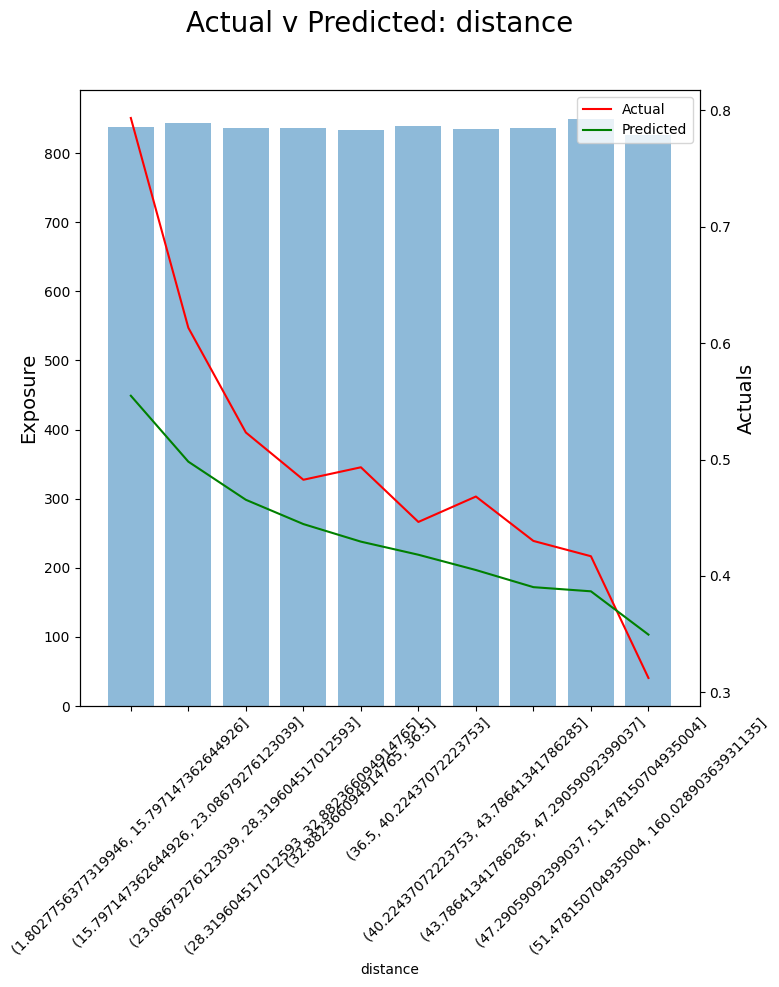

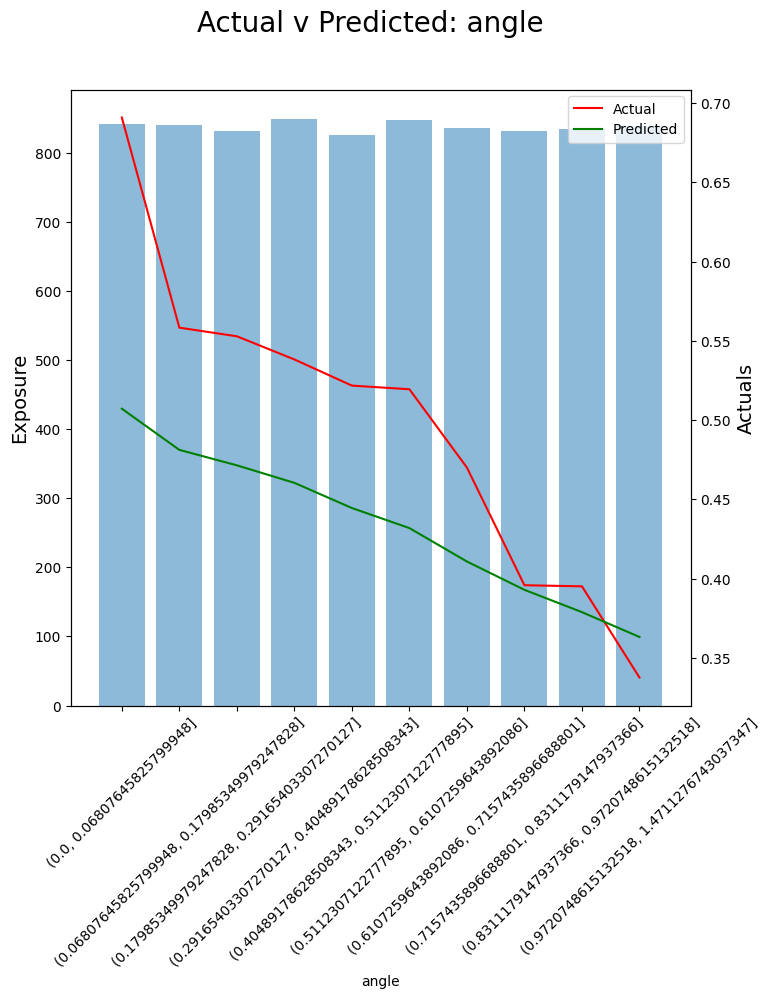

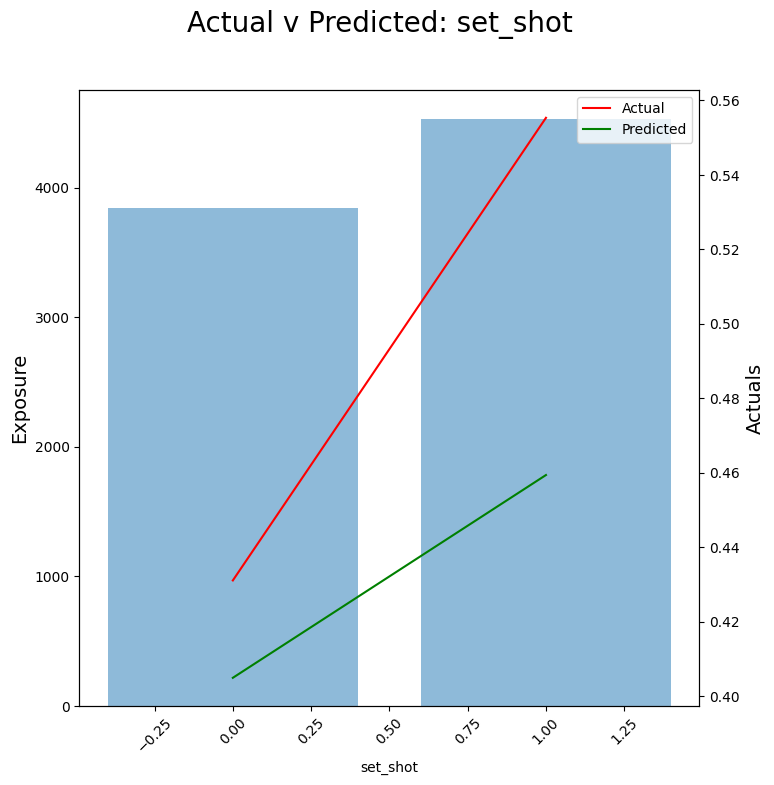

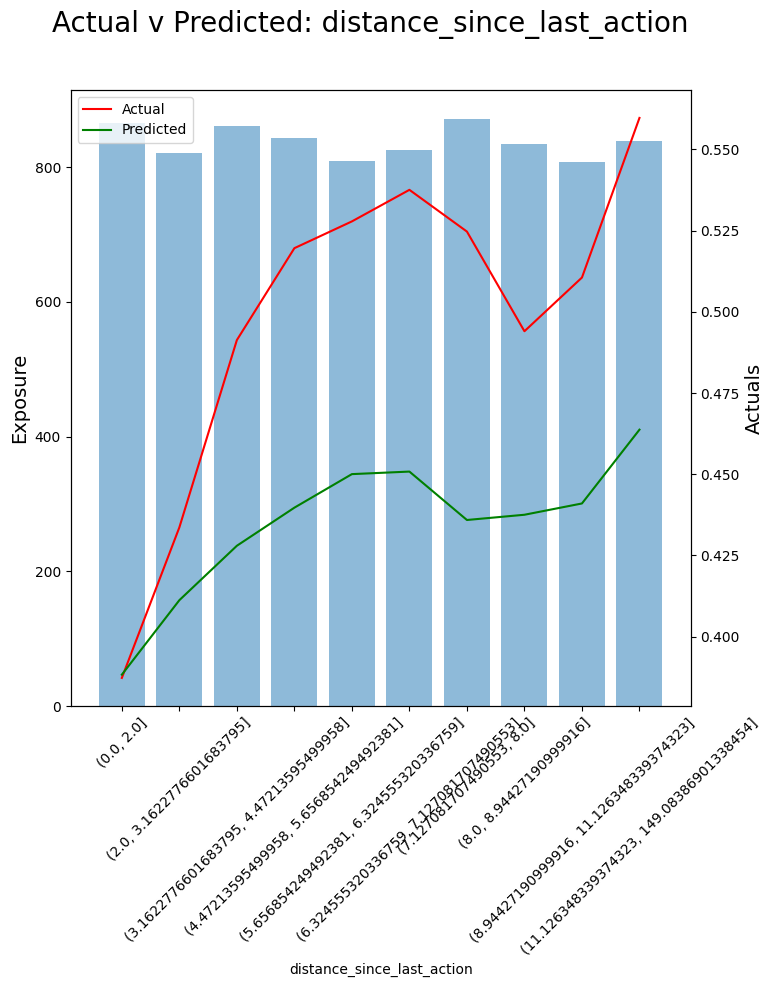

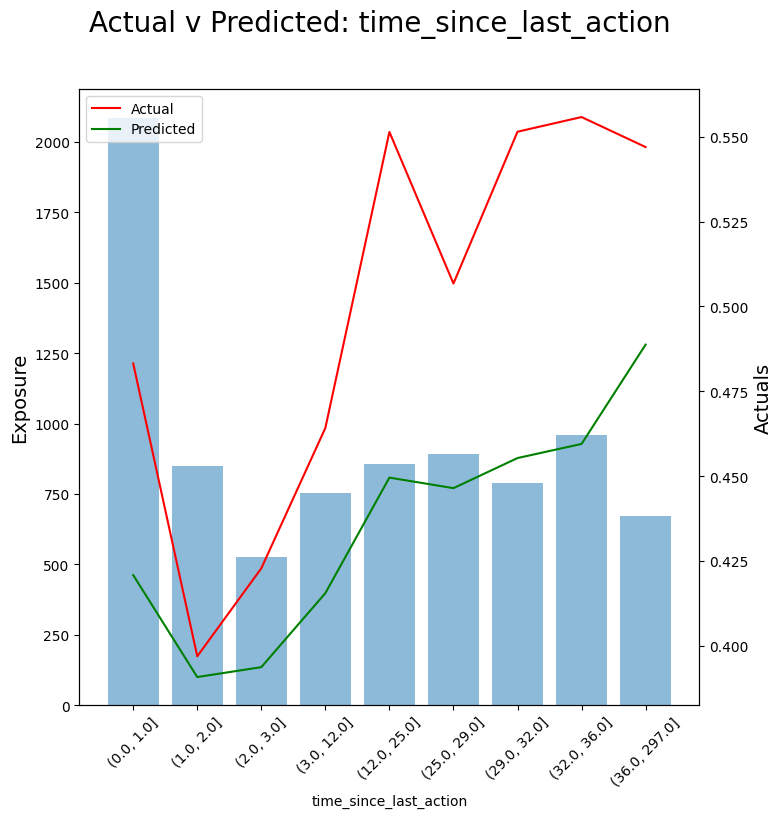

In [36]:
for feature in features:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_test[feature], feature_name = feature)

Extra Features

In [37]:
# candidate_features = sorted(list(set(X_shots.columns) - set(X_shots_selected)))
# for feature in candidate_features:
#     fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots.loc[X_test.index][feature], feature_name = feature)

Classification

In [38]:
multi_class_model_eval = ClassificationModelEvaluator(model = model, classification_type='multi')

In [39]:
actual_label = y_test
predicted_label = predicted_result

In [40]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.629335315686591,
 'class_1': 0.6476032555562761,
 'class_2': 0.44740411674433705}

In [41]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.21979359115363242,
 'class_1': 0.22766927796829917,
 'class_2': 0.13653497306529233}

Needs calibration

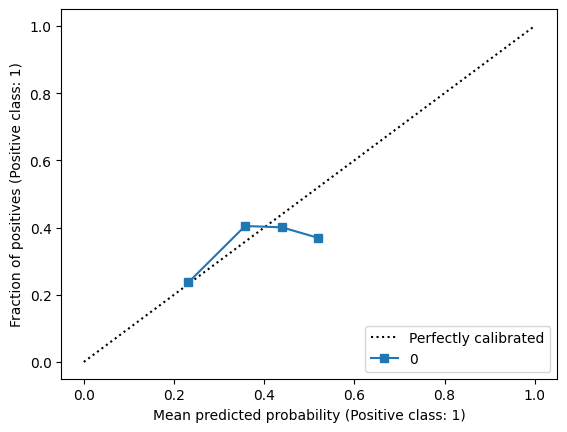

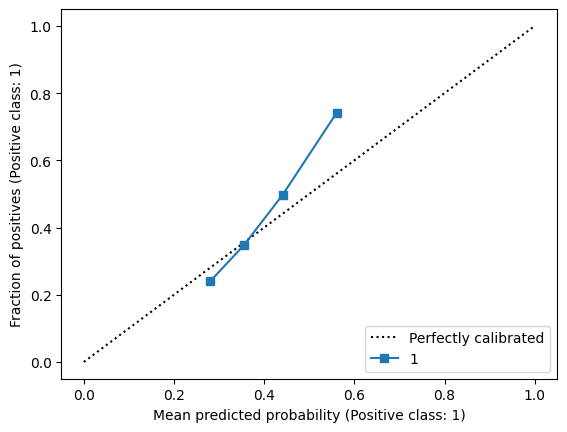

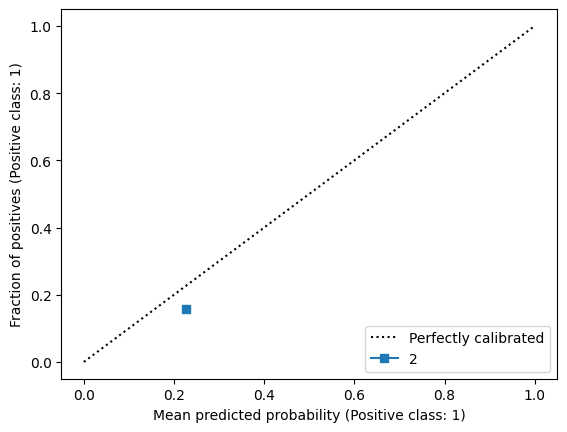

In [42]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = probas, nbins=10) 

In [43]:
multi_class_model_eval.get_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

array([[1293, 1586,    0],
       [1020, 3153,    0],
       [ 882,  441,    0]])

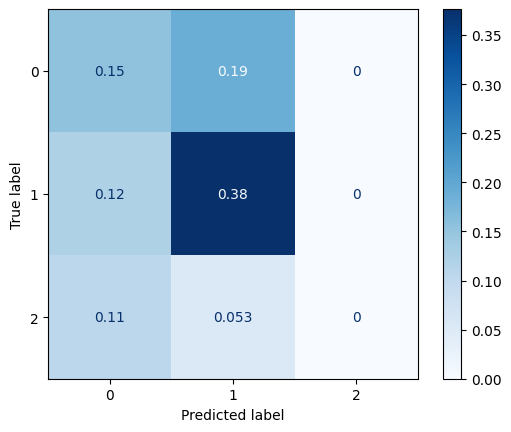

In [44]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [45]:
specified_class = 'goal'
class_label = np.where(actual_label == specified_class, 1, 0)
predicted_class_label = np.where(predicted_label == specified_class, 1, 0)

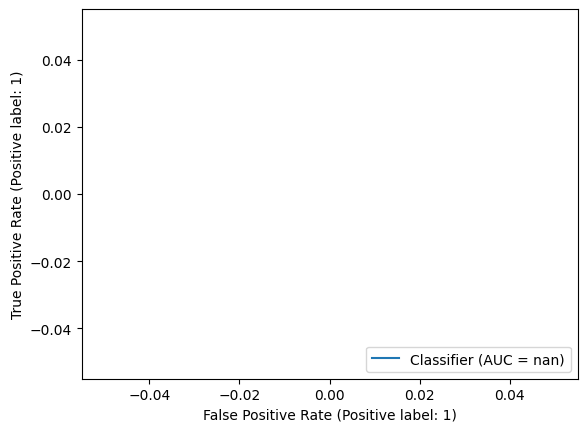

In [46]:
multi_class_model_eval.plot_roc_curve(actual_label=class_label, predicted_label=predicted_class_label)

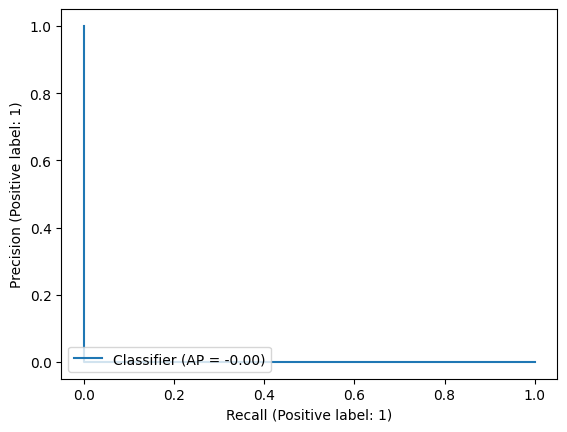

In [47]:
multi_class_model_eval.plot_prauc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [48]:
regression_model_eval = RegressionModelEvaluator(model = model)

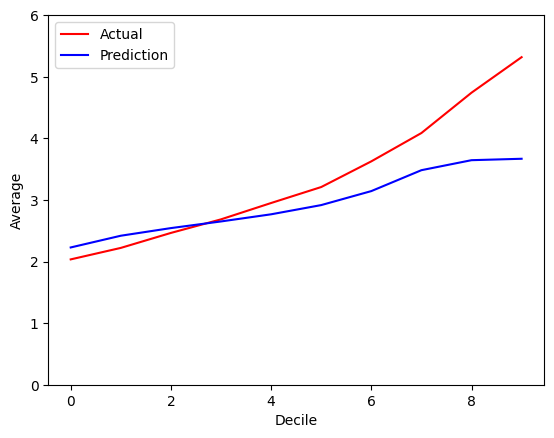

In [49]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

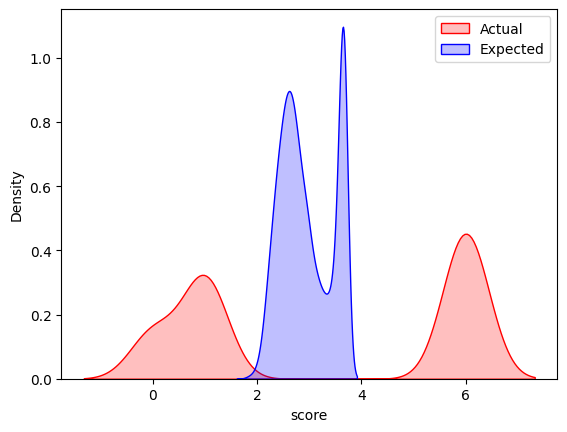

In [50]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

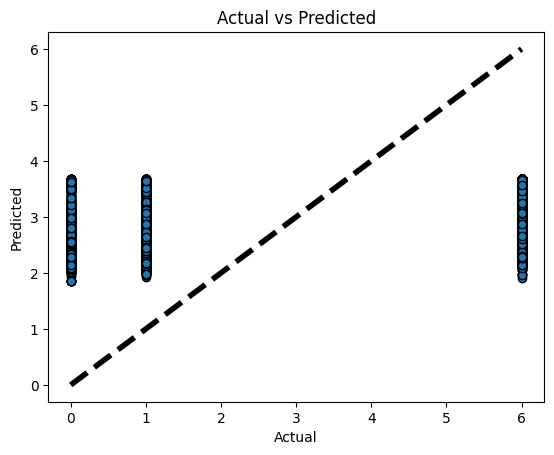

In [51]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

PyTorch Evaluation

In [52]:
pytorch_evaluator = PyTorchEvaluator(
    pytorch_model = model,
    evaluator = ClassificationModelEvaluator
)   

# Feature Importance

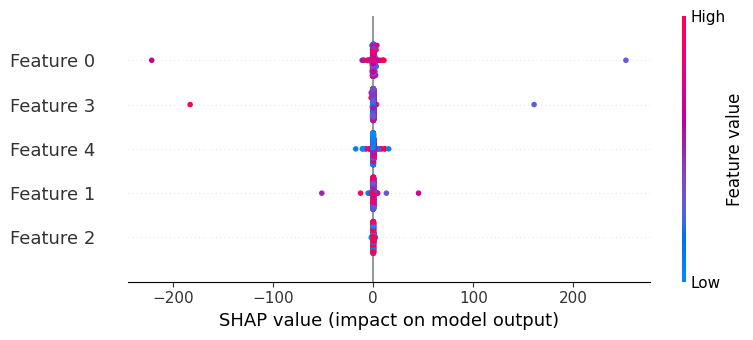

In [53]:
pytorch_evaluator.plot_shap_beeswarm(X_test_tensor[:1000], specified_class=1, max_display=10)

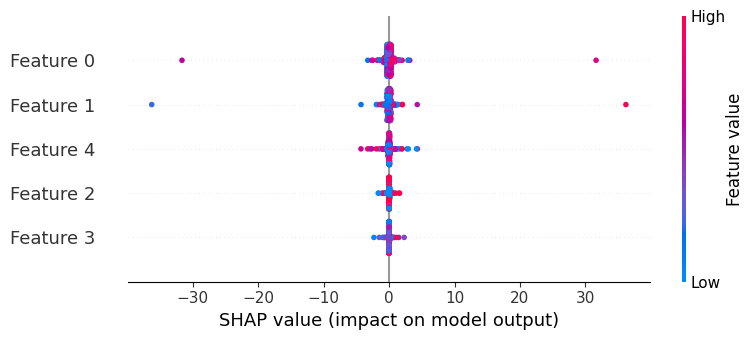

In [56]:
pytorch_evaluator.plot_shap_beeswarm(X_test_tensor[:1000], specified_class=0, max_display=10)

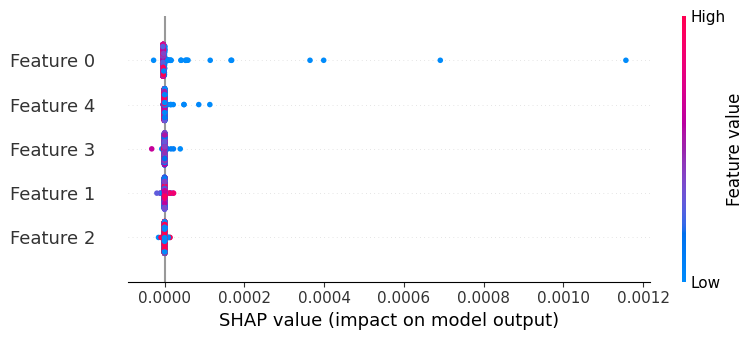

In [57]:
pytorch_evaluator.plot_shap_beeswarm(X_test_tensor[:1000], specified_class=2, max_display=10)

Export (or Upload) Predictions

In [58]:
result_map_rev = {0: 'behind', 1: 'goal', 2: 'miss'}

Decided not to use calibrated as simpler and raw probas look calibrated already.

In [59]:
shots = chains.loc[X_shots.index]
shots_tensor = torch.tensor(X_shots[selected_features].values, dtype=torch.float32)
shots['predicted_result'] = model.predict(shots_tensor)
shots[[f'{result_map_rev[x]}_probas' for x in model.classes_]] = model.predict_proba(shots_tensor)
shots['xscore'] = shots['goal_probas']*6 + shots['behind_probas']
shots = pd.concat([shots, X_shots], axis=1)
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,Description_grouped,angle,angle_degrees,chain_duration,description_grouped_0,description_grouped_1,description_grouped_2,description_grouped_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3
47,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,1,0.216884,0.569880,0.213235,3.636167,Kick,0.321751,18.434949,68.0,Kick,Mark,Kick,Other,37.947332,3.636199,8.246211,1440.0,36.0,12.0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0
111,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,0,0.396814,0.370594,0.232592,2.620376,Kick,0.942000,53.972627,57.0,Kick,Mark,Kick,Other,40.804412,3.708790,8.944272,1665.0,24.0,33.0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0
195,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,0,0.384567,0.382737,0.232696,2.680988,Kick,0.753151,43.152390,8.0,Kick,Ball Get,Gather,Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0
206,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,1,0.255715,0.522567,0.221718,3.391114,Kick,0.762147,43.667780,20.0,Kick,Free,Free,Kick,30.413813,3.414897,7.615773,925.0,22.0,21.0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0
217,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,0,0.449421,0.320416,0.230163,2.371917,Kick,0.767856,43.994914,18.0,Kick,Other,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0


In [60]:
shots.to_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_pytorch.csv", index=False)

Export Joblib

In [61]:
import joblib

In [63]:
joblib.dump(model, '/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/pytorch_model.joblib')

['/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/pytorch_model.joblib']